In [403]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Carga de Datos y Slicing

In [404]:
###función para cargar los datos y generar el dataframe ya revuelto usando Pandas
def CargaDatos():
    TrainingData = np.load('proyecto_training_data.npy')
    DataRegression = pd.DataFrame(TrainingData,columns =['SalePrice','OveralQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
    DataRegression = DataRegression.sample(frac = 1, ignore_index=True)
    DataTrain = DataRegression.iloc[0:int(len(DataRegression)*.8),:]
    DataTest = DataRegression.iloc[int(len(DataRegression)*0.8):len(DataRegression), : ]
    

    return DataRegression, DataTrain, DataTest

In [405]:
## Main del programa
DatosProyecto, DatosEntreno, DatosPruebas = CargaDatos() #carga los datos completos, el 80% para entrenamiento y el 20% para pruebas
# Se generan 3 Data Frame, uno con los datos totales, otro con los de entreno y otro con los de pruebas.
MediaDatos, MaxDatos, MinDatos, StdDatos, RangoDatos = ParametrosDatos(DatosEntreno)


In [281]:
def ParametrosDatos(a):
    MediasData = a.loc['mean']
    MaxData = a.loc['max']
    MinData = a.loc['min']
    StdData = a.loc['std']
    RangeData = a.loc['max'] - a.loc['min']
    return MediasData, MaxData, MinData, StdData, RangeData

In [406]:
print (f'Media de los datos:\n{MediaDatos}')

Media de los datos:
SalePrice       180222.306507
OveralQual           6.089041
1stFlrSF          1162.262842
TotRmsAbvGrd         6.515411
YearBuilt         1970.870719
LotFrontage         70.099372
Name: mean, dtype: float64


In [407]:

print (f'Desviación de los datos:\n{StdData}')

Desviación de los datos:
SalePrice       76827.206041
OveralQual          1.376526
1stFlrSF          388.057816
TotRmsAbvGrd        1.641010
YearBuilt          30.519185
LotFrontage        24.991742
Name: std, dtype: float64


In [408]:
print (f'Valores máximos de los datos:\n{MaxData}')

Valores máximos de los datos:
SalePrice       745000.0
OveralQual          10.0
1stFlrSF          4692.0
TotRmsAbvGrd        14.0
YearBuilt         2009.0
LotFrontage        313.0
Name: max, dtype: float64


In [409]:
print (f'Valores mínimos de los datos:\n{MinData}')

Valores mínimos de los datos:
SalePrice       34900.0
OveralQual          1.0
1stFlrSF          334.0
TotRmsAbvGrd        2.0
YearBuilt        1872.0
LotFrontage        21.0
Name: min, dtype: float64


## Histograma de la variable

<Figure size 640x480 with 0 Axes>

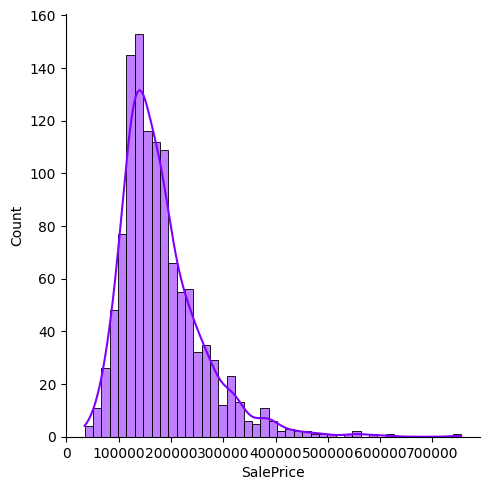

<Figure size 640x480 with 0 Axes>

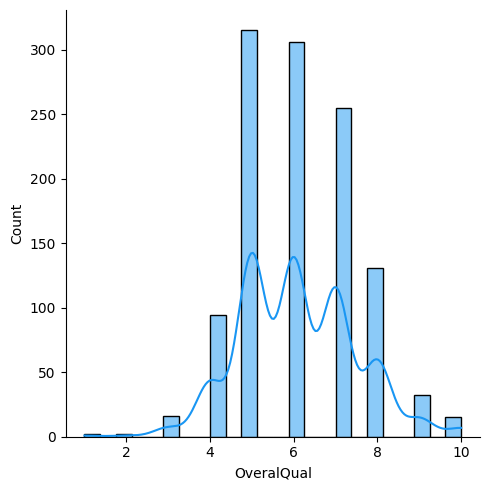

<Figure size 640x480 with 0 Axes>

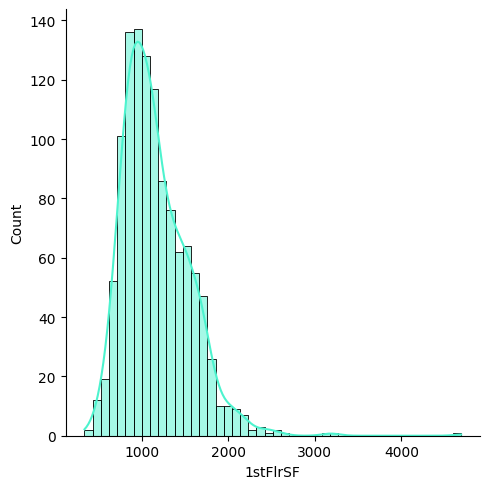

<Figure size 640x480 with 0 Axes>

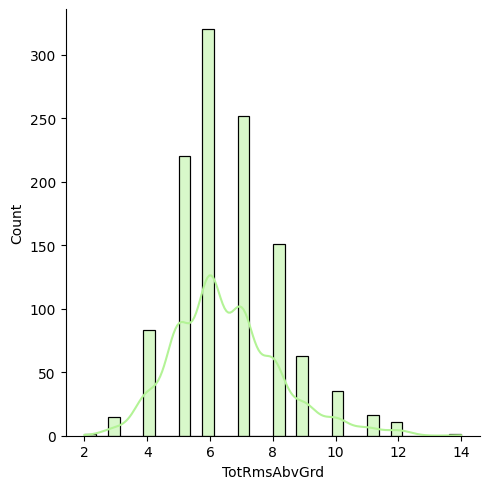

<Figure size 640x480 with 0 Axes>

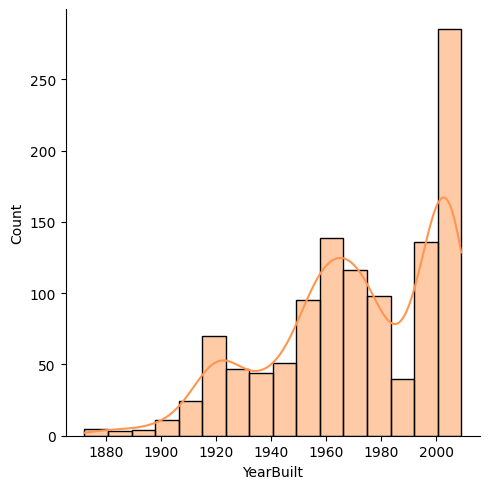

<Figure size 640x480 with 0 Axes>

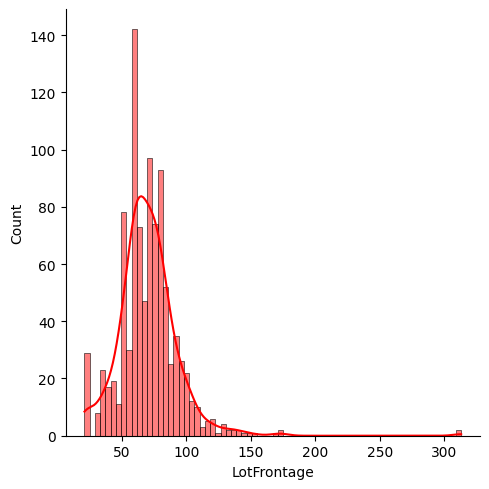

In [410]:
ColorHist = cm.rainbow(np.linspace(0,1,(DatosEntreno.shape[1])))

Ban = 0
for column in DatosEntreno:
    plt.figure()
    sb.displot(DatosEntreno[column], kde = True, color = ColorHist[Ban])
    Ban = Ban + 1

## Calcular el coeficiente de correlación de cada variable


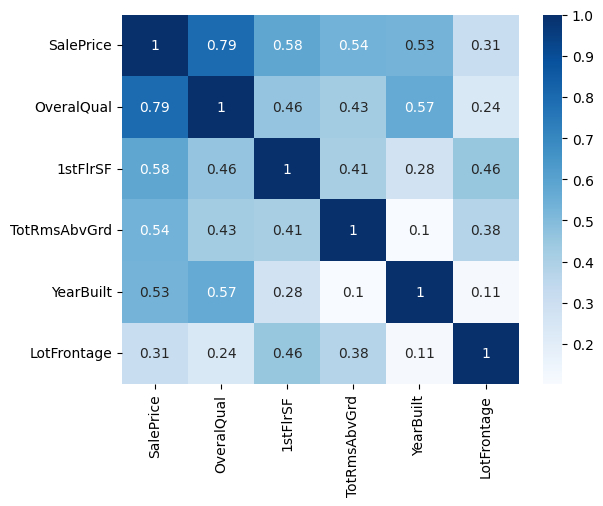

In [411]:
plt.figure()
correlacones = DatosEntreno.corr()
GrafiCorr = sb.heatmap(correlacones, annot = True, cmap = 'Blues',fmt = '0.2g')

## Scatterplot con Correlación como título

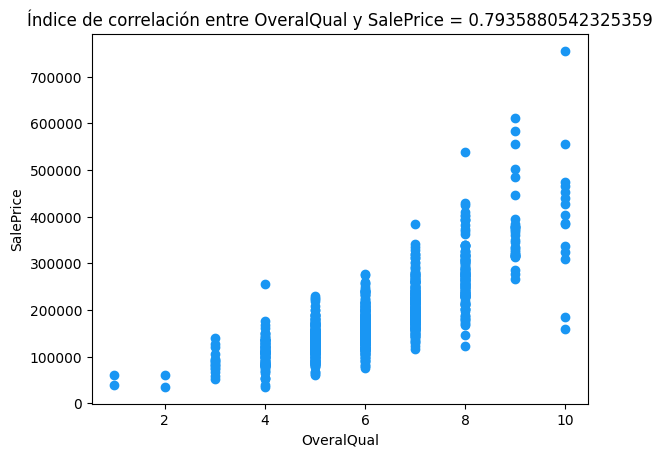

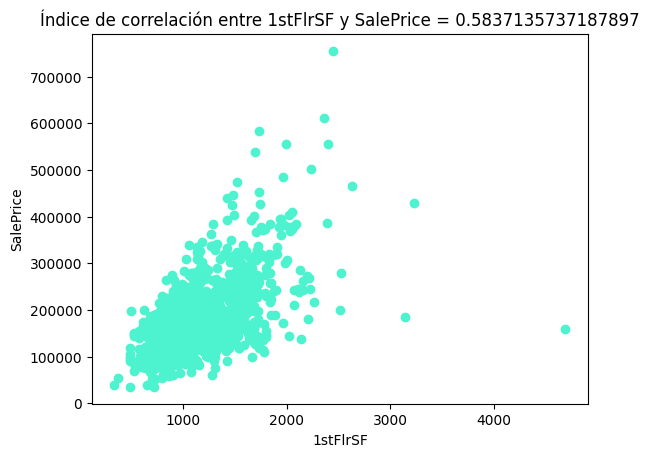

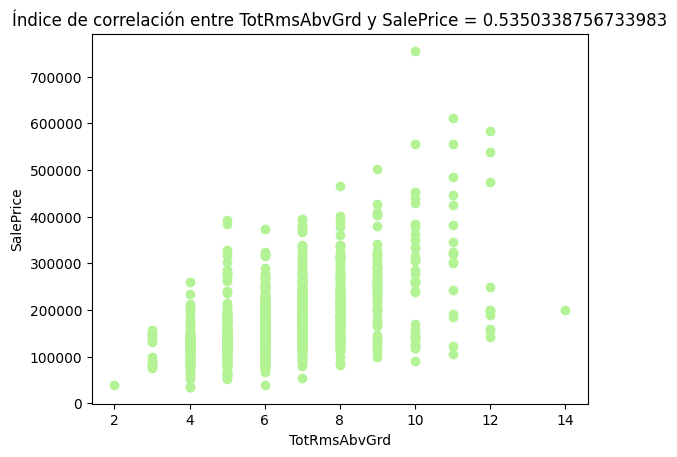

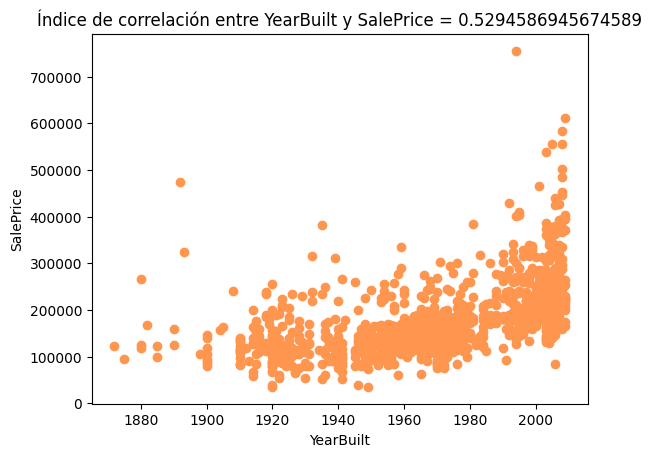

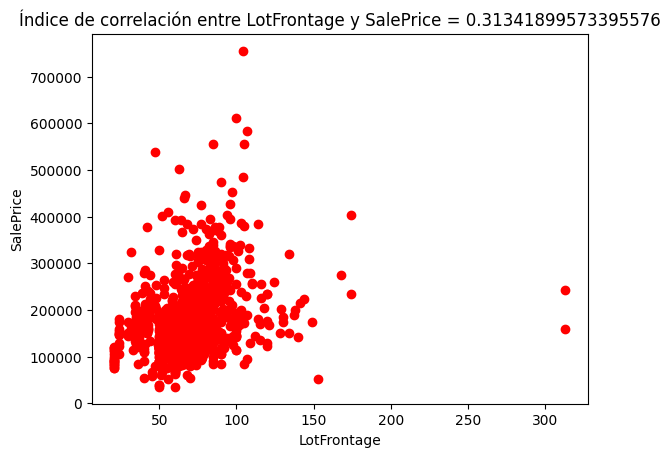

In [412]:
CorrPrecio = DatosEntreno.corr()['SalePrice']
colores = cm.rainbow(np.linspace(0,1,len(CorrPrecio)))
Bandera = 0
for value in DatosEntreno:
    if value != 'SalePrice':
        Bandera = Bandera + 1
        plt.figure()
        plt.title(f'Índice de correlación entre {value} y SalePrice = {CorrPrecio[Bandera]}')
        plt.xlabel(value)
        plt.ylabel('SalePrice')
        plt.scatter(DatosEntreno[value],DatosEntreno['SalePrice'], color = colores[Bandera])

In [484]:
#### funcion para el construir el modelo
def RegModel(xData,yData,epochs,LearningRate):
    beta1 = 0.001
    beta0 = 0.001
    yOriginal = yData.to_numpy().reshape(-1,1)
    errorvec = []
    iter = []
    HistoricBetas = []
    x = xData.to_numpy().reshape(-1,1)
    ones = np.ones_like(x)
    ones = ones.reshape(-1,1)
    Vec = np.hstack([x,ones])
    betas = np.array([beta1,beta0]).reshape(-1,1)
    HistoricBetas.append([beta1,beta0])
    for index in range (epochs):
        result = np.dot(Vec,betas)
        error = 0.5*np.mean(np.power((result-yOriginal),2))
        DelBeta1 = np.mean((result - yOriginal)*x)
        DelBeta0 = np.mean(result - yOriginal)
        beta1 = beta1 - LearningRate*DelBeta1
        beta0 = beta0 - LearningRate*DelBeta0
        betas = np.array([beta1,beta0]).reshape(-1,1)
        errorvec.append(error)
        iter.append(index)
        HistoricBetas.append(np.array([beta1,beta0]))
    yfinal = beta1*x + beta0
    GraphError = plt.figure()
    plt.title('Gráfica error modelo')
    plt.xlabel('Iteraciones')
    plt.ylabel('Error')
    plt.plot(iter,errorvec, color = 'green')
    GraphModelo = plt.figure()
    plt.title(f'Modelo de regresión y = {round(beta1,3)}x + {round(beta0,3)}')
    plt.xlabel(f'Variable independiente {xData.name}')
    plt.ylabel(f'Variable dependiente{yData.name}')
    plt.scatter(x,yOriginal)
    plt.plot(x,yfinal, color = 'red')
    return beta1, beta0, HistoricBetas, iter, errorvec, GraphModelo, GraphError



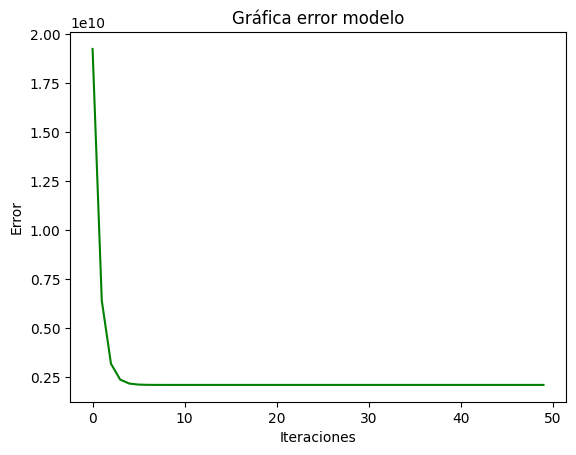

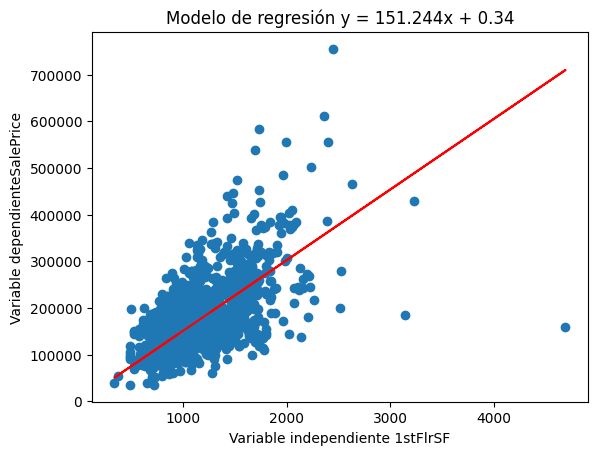

In [485]:
beta1, beta0, HistoricBetas, iter, errorvec, GraphModelo, GraphError = RegModel(DatosEntreno['1stFlrSF'],DatosEntreno['SalePrice'],50,0.000001)

## Clase para modelo

In [503]:
class RegLin():
    def __init__(self, epochs, LearnRate, xData, yData, print_itr):
        self.epochs = epochs
        self.LearningRate = LearnRate
        self.x = xData
        self.y = yData
        self.FinalY = []
        self.print_iters = print_itr
        self.beta0 = 0
        self.beta1 = 0
        self.HistoricBetas = []
        self.HistoricError = []
        self.iter = []
    ### Método para regresion   
    def MetodoReg(self):
        self.beta1 = 0.001
        self.beta0 = 0.001
        yOriginal = self.y.to_numpy().reshape(-1,1)
        self.FinalY = []
        self.HistoricBeta = []
        self.HistoricError = []
        self.iter = []
        x = self.x.to_numpy().reshape(-1,1)
        ones = np.ones_like(x)
        ones = ones.reshape(-1,1)
        Vec = np.hstack([x,ones])
        betas = np.array([self.beta1,self.beta0]).reshape(-1,1)
        self.HistoricBetas.append([self.beta1,self.beta0])
        for index in range (self.epochs):
            result = np.dot(Vec,betas)
            error = 0.5*np.mean(np.power((result-yOriginal),2))
            DelBeta1 = np.mean((result - yOriginal)*x)
            DelBeta0 = np.mean(result - yOriginal)
            self.beta1 = self.beta1 - self.LearningRate*DelBeta1
            self.beta0 = self.beta0 - self.LearningRate*DelBeta0
            betas = np.array([self.beta1,self.beta0]).reshape(-1,1)
            self.HistoricError.append(error)
            self.iter.append(index)
            self.HistoricBetas.append(np.array([self.beta1,self.beta0]))
        self.YFinal = self.beta1*x + self.beta0
    #### Método para graficar el error total
    def PlotError(self):
        plt.figure()
        plt.title('Gráfica error modelo')
        plt.xlabel('Iteraciones')
        plt.ylabel('Error')
        plt.plot(self.iter,self.HistoricError, color = 'green')
    #### Método para graficar el modelo vs scatterplot
    def PlotModelo(self):
        GraphModelo = plt.figure()
        plt.title(f'Modelo de regresión y = {round(self.beta1,3)}x + {round(self.beta0,3)}')
        plt.xlabel(f'Variable independiente {self.x.name}')
        plt.ylabel(f'Variable dependiente{self.y.name}')
        plt.scatter(self.x.to_numpy().reshape(-1,1),self.y.to_numpy().reshape(-1,1))
        plt.plot(self.x.to_numpy().reshape(-1,1),self.YFinal, color = 'red')

In [504]:
PruebaReg = RegLin(50,0.000001,DatosEntreno['1stFlrSF'],DatosEntreno['SalePrice'],10)

In [502]:
del PruebaReg

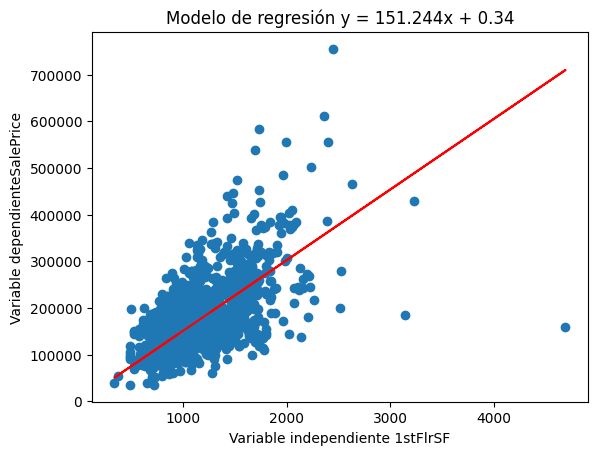

In [505]:
PruebaReg.MetodoReg()

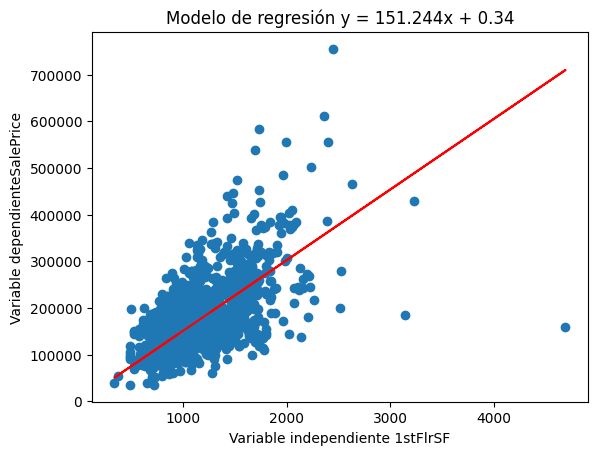

In [506]:
PruebaReg.PlotModelo()

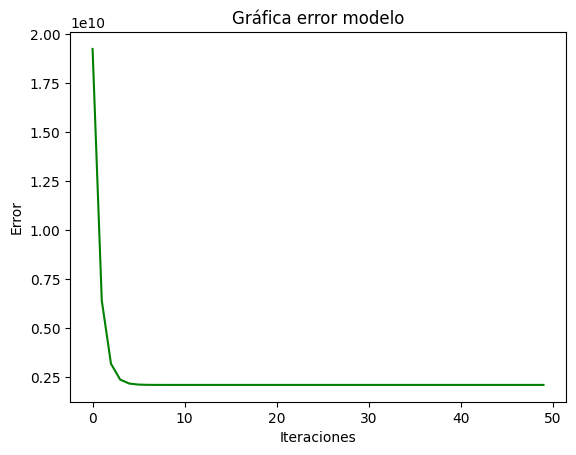

In [489]:
PruebaReg.PlotError()